## Fifa players change log

#### 28/02/25
- I have decided to use a fifa players dataset that I obtained from here: https://www.kaggle.com/datasets/stefanoleone992/fifa-23-complete-player-dataset/data?select=male_players.csv
- I am only using the male players dataset as there is too much data otherwise.
- I have had to reduce my dataset to 1 million random rows as my initial dataset was way too much for my machine to handle.

#### 02/02/25
- I took out goalkeepers as I only want to focus on outfield players, this is because they require a lot of different metrics to judge them by and I believe it will throw the model off for clustering.
- I had to remove a few fields as they were becoming to dependant when I was building the model.
- I now have a good level of clustering working based off of the players stats and overall rating.
- Outliers will always exist as different players play differently to each other.
- PCA helped to analyse how the model is working.
- I had to remove the bigger csv files that were mentioned in the code as github doesnt accept file uploads above 100mbs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('male_players.csv')

df_sample = df.sample(n=1000000, random_state=42)

df_sample.to_csv("Fifa-Sample.csv", index=False)

/var/folders/jp/fbwfkpy50vs_7m6dlkzl468h0000gn/T/ipykernel_74631/2767710571.py:7: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('male_players.csv')


I had to extract this csv as the orginal one is way too big for my machine to handle, it is sitting at 5gb in size and is well over 10 million rows in size.

I decided to take a million of these rows at random using random state 42 and n as 1,000,000. This should give me a lot of data to work with but still able to run relatively quickly on my system. If I had more time I would try adn run this externally with the full dataset to see the difference in the results with all players.

Now I am going to drop all of the unneeded columns from the dataset.

I'm also going to drop the goalkeepers as this model will only be focusing on outfield players.

In [5]:
import pandas as pd

df = pd.read_csv('Fifa-Sample.csv')

df = df[['long_name', 'player_positions', 'overall', 'value_eur', 'weak_foot', 'skill_moves', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']]

df = df[~df['player_positions'].str.contains('gk', case=False, na=False)] #ChatGpt gave me this line as I was having trouble with my initial method - AD

df = df.dropna()

df.to_csv("Filtered-Fifa-Sample.csv", index=False)

Now that I have my filtered datasets with the necessary data, I can start building the model following the same process that I used in my previous model. 

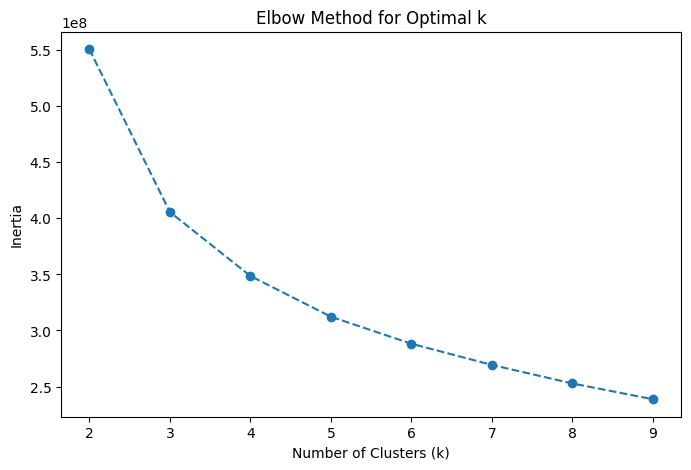

In [13]:
from sklearn.cluster import KMeans

X = df[['overall', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']]

inertia = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

#  This method was explained to me by ChatGPT, it is a method to determine the optimal number of clusters for the data. The optimal point to choose for the cluster is where the slope starts tailing off so in this example it would be 6/7 - AD

I am using this again here to figure out the best number of features that I can use for my cluster.

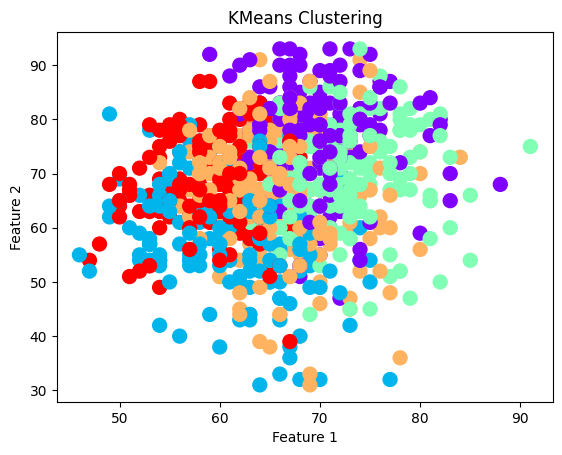

In [17]:
import numpy as np
import matplotlib.pyplot as plt

X_sample = X.sample(n=1000, random_state=42)  # Take 5000 random rows

# Convert DataFrame to NumPy array
X_np = X_sample.to_numpy() # This line was added by chatGPT to convert the dataframe to a numpy array as I was having issues figuring out why it wouldn't plot - AD

est = KMeans(n_clusters=5, random_state=42)
est.fit(X_np)

y_kmeans = est.predict(X_np)

plt.scatter(X_np[:, 0], X_np[:, 1], c=y_kmeans, s=100, cmap='rainbow')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KMeans Clustering")
plt.show()

As you can see the data is clustering relatively well. I decided to take a small subset of the data to illustrate the cluster for visual purposes.
I did this by just taking a random 1000 rows from the dataset. 

This dataset will always have outliers as there are going to be players with different playstyles and attributes which will affect the data for stuff like clustering. For example a more attacking minded fullback will be different on the cluster compared to a defensive minded one as their stats focus on different aspects of the game.


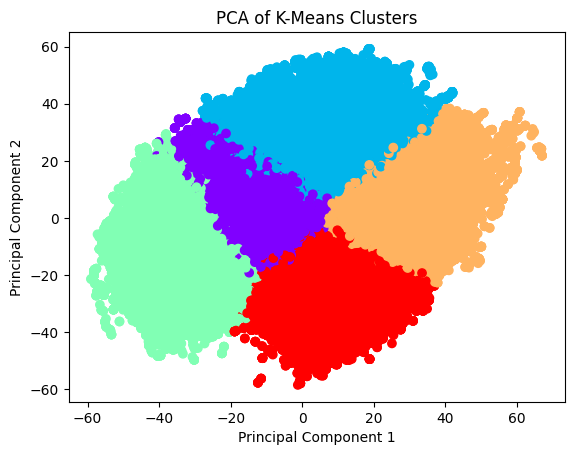

Feature Contributions to Principal Components:
      overall  weak_foot  skill_moves      pace  shooting   passing  \
PC1  0.092366   0.009150     0.018991  0.303628  0.585675  0.270342   
PC2  0.321238   0.005311     0.006674  0.046768  0.234857  0.442394   

     dribbling  defending    physic  
PC1   0.389173  -0.557685 -0.142360  
PC2   0.297177   0.658296  0.349297  


In [12]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='rainbow')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of K-Means Clusters")
plt.show()

# Show feature importance
print("Feature Contributions to Principal Components:")
print(pd.DataFrame(pca.components_, columns=X.columns, index=["PC1", "PC2"]))
# The above code was added by ChatGPT to show the feature contributions to the principal components - AD


I got this block from ChatGPT and what it is doing is using PCA to determine what the model is basing its clustering off of.

As can be seen in the chart below the graph, pace and shooting are high stats where as defending and physical are very low, this would indicate that it is seperating the attacking and defending players.

This is the primary aspect that it is basing the players off of, then in PC2 it seems to be looking for more technically minded players comppared to more physical players which helps in differentiating between different playstyles in certain positions such as full back and centre midfield as these positions have so many different styles of playing the game.